In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from matplotlib import cm
#import calendar
os.chdir('/home/548/eh6215/python/BARPA_evaluation/lib')
import region_aggregation
import spatial_selection
import barpa_drs_interface
import agcd_interface
os.chdir('/home/548/eh6215/python/BARPA_evaluation/emma/PBE')
import datasets
import datetime as dt
import geopandas

In [2]:
# load observational datasets

nino = datasets.nino()
dmi = datasets.dmi()
dmi=dmi.rolling(3,center=True).mean()[1:-1]
dmi.index = dmi.index.to_series().apply(lambda x: dt.datetime(x.year,x.month,1))
sam = datasets.sam()

In [3]:
def annotate(pcolormesh,data,string):
    """
    adds text to pcolormesh. Colour of text is black or white depending on lightness of underlying figure
    Parameters
    ----------
    pcolormesh: matplotlib.pyplot.pcolormesh 
        plot object to extract colours from
    data: numpy.array 
        2D data values for text (should be array used to create pcolormesh)
    string: char
        string format for text
    """
    amp = (np.array(cm.get_cmap(x.cmap)(x.norm(data)))**2).mean(axis=2)
    print(amp.shape,data.shape)
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            plt.text(i,j,string%data[j,i],color=['k','w'][int(amp[j,i]<0.4)],ha='center',va='center')
    cm.get_cmap('BrBG')(1)

In [4]:
def make_composites(data,indices):
    """
    Composites xarray by a dictionary of binary indices. Monthly data is assumed
    Parameters
    ----------
    data: dictionary
        dictionary of xarrays to create composite from. Must contain a 'time' coordinate. Dictionary key should be model names
    indices: dictionary
        dictionary of binary monthly pandas time-series dated to the first day of the month. 
    Returns
    -------
    x-array
        composited data with a new 'index' dimension indicating composite index, 
    list 
        labels corresponding to index and model keys
    """
    array = []
    labels = []
    i = 0
    for index in indices:
        for model in data:
            subset=data[model][[(indices[index][dt.datetime(year,month,1)]  if dt.datetime(year,month,1) in indices[index].index else False) \
                 for (year,month) in zip(data[model]['time.year'].values,data[model]['time.month'].values)]]
            array.append(subset.mean('time').expand_dims(index=[i]))
            labels.append(model+" "+index)
            i+=1
    return xr.concat(array,dim='index'),labels

In [5]:
# load land-sea masks 
mask = {}
mask['AGCD'] = xr.load_dataset("/g/data/tp28/dev/evaluation_datasets/awap_mask.nc").data_mask
mask['BARPA_ERA5'] = xr.load_dataset("/g/data/tp28/dev/evaluation_datasets/BARPA-R_landseamask.nc").land_binary_mask[11:447,11:788]
mask['BARPA_ERA5'] =mask['BARPA_ERA5'].rename({'longitude':'lon','latitude':'lat'})

In [6]:
# load and format precipitation data
pr = {}
pr['BARPA_ERA5'] = barpa_drs_interface.get_barpa("ECMWF-ERA5",'evaluation','mon','pr',[dt.datetime(1979,1,1),dt.datetime(2008,12,31)],as_iris=False)
month_length = pr['BARPA_ERA5'].time.dt.days_in_month
pr['BARPA_ERA5']['pr'] = pr['BARPA_ERA5']['pr']*86400*month_length
pr['AGCD'] = agcd_interface.get_agcd('monthly', 'precip', trange=[dt.datetime(1979,1,1),dt.datetime(2008,12,31)])
pr['AGCD'] = pr['AGCD'].rename({'precip':'pr'})

agg_pr = {}
order = [5,2,6,0,1,4,3,7]
for model in pr:
    # aggregate by region
    agg_pr[model],clusters = region_aggregation.region_aggregation(pr[model]['pr'],model.split('_')[0],landmask=mask[model])
    # reorder by increasing latitude (hard-coded order)
    agg_pr[model].values = agg_pr[model].values[:,order]
    clusters=clusters[order]
    # normalise by area mean rainfall
    agg_pr[model] = agg_pr[model]/agg_pr[model].mean('time')
    # remove seasonal cycle
    agg_pr[model] = agg_pr[model].groupby("time.month") - agg_pr[model].groupby("time.month").mean("time")  
    # close netcdf file as data has been loaded
    pr[model].close()
    
# shorten longest name
clusters[6] = "S&SW Flatlands"    

Found 30 files
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_197901-197912.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198001-198012.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198101-198112.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198201-198212.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198301-198312.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198401-198412.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198501-198512.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198601-198612.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198701-198712.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198801-198812.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198901-198912.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_199001-199012.nc
pr_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_1

In [7]:
# composite by ENSO and IOD
pr_nino,indices_nino = make_composites(agg_pr, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)})
pr_iod,indices_iod = make_composites(agg_pr, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)})

In [8]:
# subset time-series to summer and winter means
summer,winter = {},{}
is_summer = lambda x: (x >= 11) | (x <=3)
is_winter = lambda x: (x >= 5) & (x <=9)
for model in pr:
    summer[model] = agg_pr[model].sel(time=is_summer(agg_pr[model]['time.month']))
    winter[model] = agg_pr[model].sel(time=is_winter(agg_pr[model]['time.month']))
    
# composite by SAM: treat summer and winter separately
pr_sam_summer,indices_sam = make_composites(summer, {"Negative SAM":(sam<-1),"Positive SAM":(sam>1)})
pr_sam_winter,indices_sam = make_composites(winter, {"Negative SAM":(sam<-1),"Positive SAM":(sam>1)})
 

(4, 8) (4, 8)
(4, 8) (4, 8)


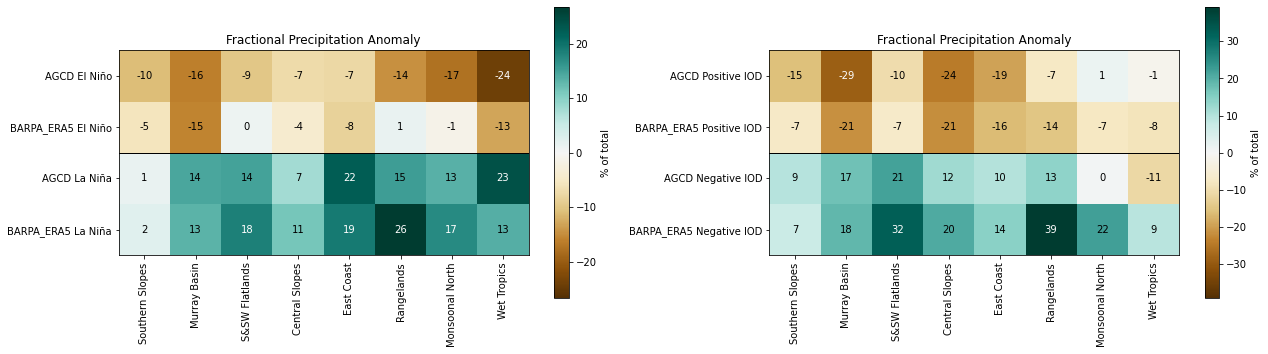

In [9]:
# make figures: fractional precip anomalies during ENSO and IOD
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
# draw pcolormesh
x=(100*pr_nino).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
# set ticks
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
# draw dividing line
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
# add text on pcolormesh
annotate(x,100*pr_nino.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
# draw pcolormesh
x=(100*pr_iod).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
# set ticks
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
# draw dividing line
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
# add text on pcolormesh
annotate(x,100*pr_iod.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

(4, 8) (4, 8)
(4, 8) (4, 8)


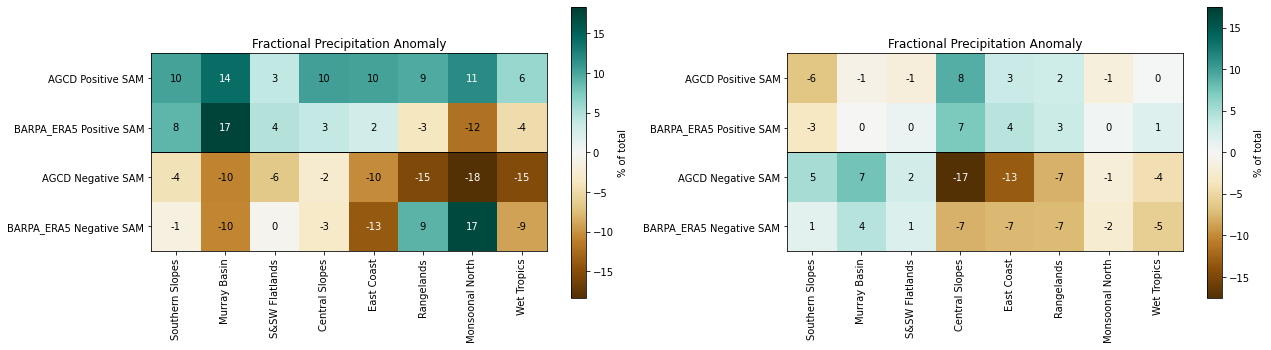

In [10]:
# make figures: fractional precip anomalies during SAM (summer and winter)
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(100*pr_sam_summer).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_sam)),indices_sam)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_sam_summer.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(100*pr_sam_winter).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_sam)),indices_sam)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_sam_winter.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()



In [11]:
# load and format monthly mean daily maximum temperature data
tmax = {}
tmax['BARPA_ERA5'] = barpa_drs_interface.get_barpa("ECMWF-ERA5",'evaluation','mon','tasmax',[dt.datetime(1979,1,1),dt.datetime(2008,12,31)],as_iris=False)
tmax['AGCD'] = agcd_interface.get_agcd('monthly', 'tmax', subversion='mean', trange=[dt.datetime(1979,1,1),dt.datetime(2008,12,31)])
tmax['AGCD'] = tmax['AGCD'].rename({'tmax':'tasmax'})
tmax['BARPA_ERA5']=tmax['BARPA_ERA5'].drop_vars('height')


agg_tmax = {}
for model in tmax:
    agg_tmax[model],clusters = region_aggregation.region_aggregation(tmax[model]['tasmax'],model.split('_')[0],landmask=mask[model])
    agg_tmax[model].values = agg_tmax[model].values[:,order]
    agg_tmax[model] = agg_tmax[model].groupby("time.month") - agg_tmax[model].groupby("time.month").mean("time")  
    clusters=clusters[order]
    agg_tmax[model].close()
    
clusters[6] = "S&SW Flatlands"    

Found 30 files
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_197901-197912.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198001-198012.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198101-198112.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198201-198212.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198301-198312.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198401-198412.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198501-198512.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198601-198612.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198701-198712.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198801-198812.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198901-198912.nc
tasmax_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_199001-199012.nc
tasmax_AUS-15

In [12]:
# composite by ENSO and IOD
tmax_nino,indices_nino = make_composites(agg_tmax, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)})
tmax_iod,indices_iod = make_composites(agg_tmax, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)})    

(4, 8) (4, 8)
(4, 8) (4, 8)


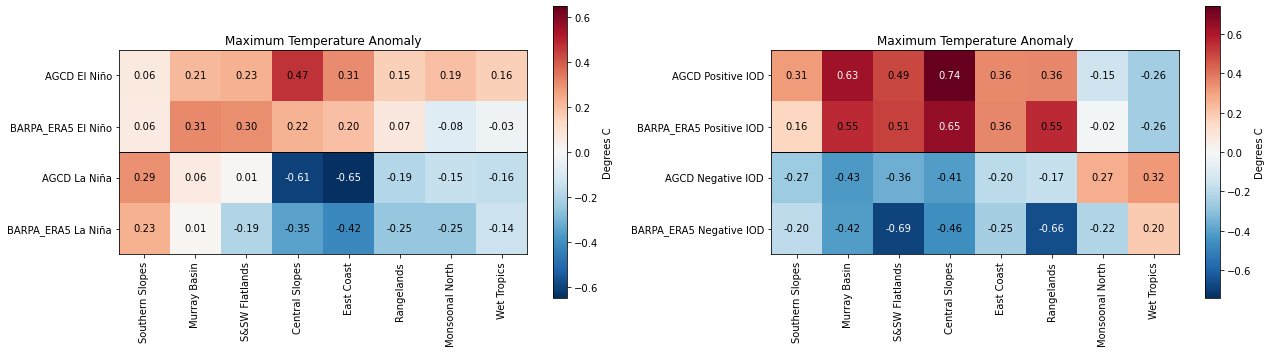

In [13]:
# make figures: tasmax anomalies during ENSO and IOD
plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(tmax_nino).plot.pcolormesh(cbar_kwargs = {'label':'Degrees C'})
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmax_nino.values,"%.2f")
plt.title("Maximum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(tmax_iod).plot.pcolormesh(cbar_kwargs = {'label':"Degrees C"})
plt.xticks(range(len(clusters)),clusters,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmax_iod.values,"%.2f")
plt.title("Maximum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()

In [14]:
# load and format monthly mean daily maximum temperature data

tmin = {}
tmin['BARPA_ERA5'] = barpa_drs_interface.get_barpa("ECMWF-ERA5",'evaluation','mon','tasmin',[dt.datetime(1979,1,1),dt.datetime(2008,12,31)],as_iris=False)
tmin['AGCD'] = agcd_interface.get_agcd('monthly', 'tmin', subversion='mean', trange=[dt.datetime(1979,1,1),dt.datetime(2008,12,31)])
tmin['AGCD'] = tmin['AGCD'].rename({'tmin':'tasmin'})
tmin['BARPA_ERA5']=tmin['BARPA_ERA5'].drop_vars('height')


agg_tmin = {}
for model in tmin:
    agg_tmin[model],labels = region_aggregation.region_aggregation(tmin[model]['tasmin'],model.split('_')[0],landmask=mask[model])
    agg_tmin[model].values = agg_tmin[model].values[:,order]
    agg_tmin[model] = agg_tmin[model].groupby("time.month") - agg_tmin[model].groupby("time.month").mean("time")  
    clusters=clusters[order]
    agg_tmin[model].close()
    
clusters[6] = "S&SW Flatlands"        

Found 30 files
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_197901-197912.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198001-198012.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198101-198112.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198201-198212.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198301-198312.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198401-198412.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198501-198512.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198601-198612.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198701-198712.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198801-198812.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_198901-198912.nc
tasmin_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_mon_199001-199012.nc
tasmin_AUS-15

In [15]:
# composite by ENSO and IOD
tmin_nino,indices_nino = make_composites(agg_tmin, {"La Niña":(nino<-0.8),"El Niño":(nino>0.8)})
tmin_iod,indices_iod = make_composites(agg_tmin, {"Negative IOD":(dmi<-0.4),"Positive IOD":(dmi>0.4)})    

(4, 8) (4, 8)
(4, 8) (4, 8)


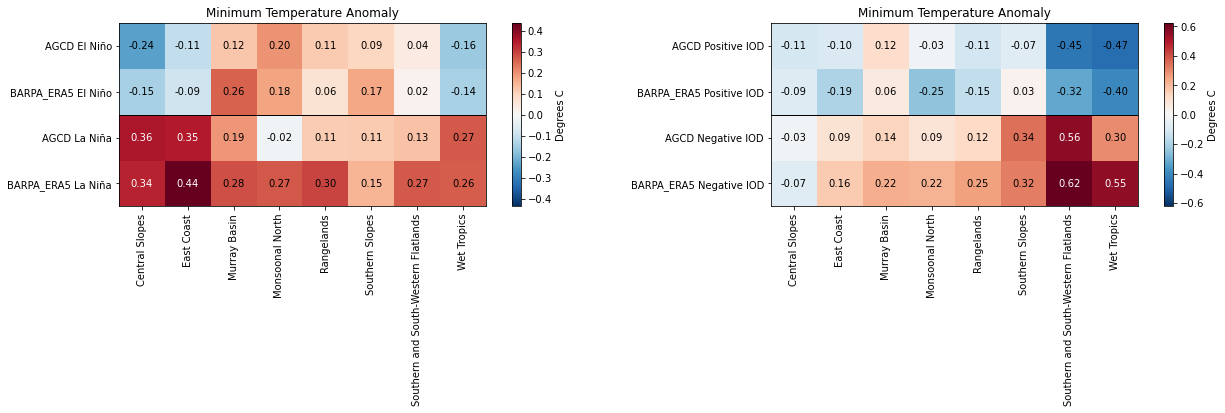

In [16]:
# make figures: tasmin anomalies during ENSO and IOD

plt.figure(figsize=(18,5))
plt.subplot(121,aspect=1)
x=(tmin_nino).plot.pcolormesh(cbar_kwargs = {'label':'Degrees C'})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_nino)),indices_nino)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmin_nino.values,"%.2f")
plt.title("Minimum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")

plt.subplot(122,aspect=1)
x=(tmin_iod).plot.pcolormesh(cbar_kwargs = {'label':"Degrees C"})
plt.xticks(range(len(labels)),labels,rotation=90)
plt.yticks(range(len(indices_iod)),indices_iod)
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,tmin_iod.values,"%.2f")
plt.title("Minimum Temperature Anomaly")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()